Image shape: (512, 768, 3) dtype: float32
Decoded identical to original: True
Compression ratio: 2.077


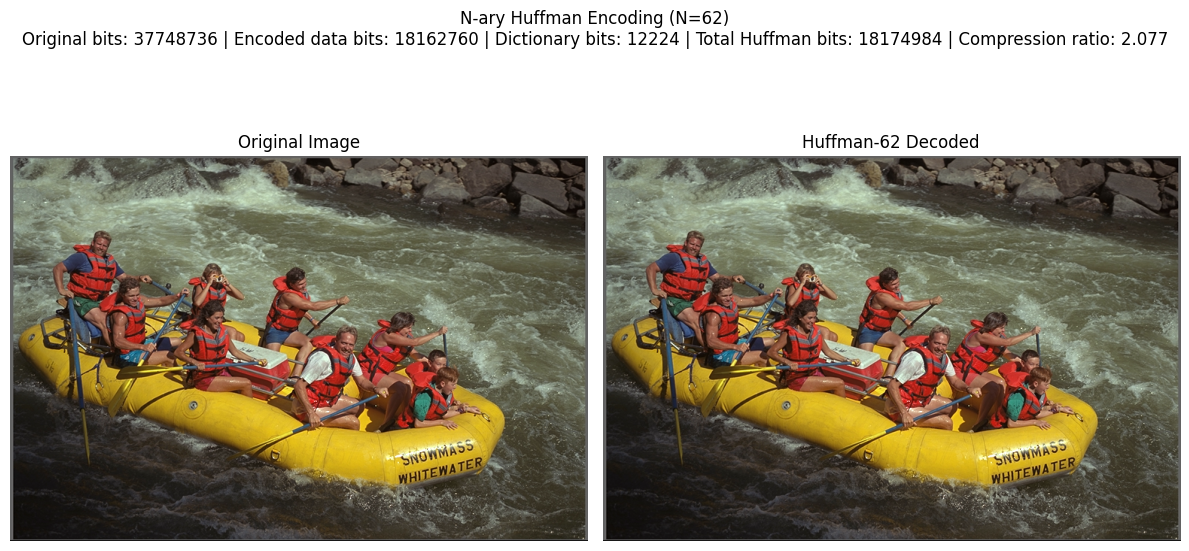

In [8]:
import numpy as np
from collections import Counter
import string
import matplotlib.pyplot as plt

# ---------------- Allowed symbols for N-ary Huffman ---------------- #
SYMBOLS = string.digits + string.ascii_uppercase + string.ascii_lowercase

# ---------------- Huffman Utilities ---------------- #
def build_nary_huffman(freqs, base):
    heap = [[f, [[sym, ""]]] for sym, f in freqs.items()]
    while len(heap) > 1:
        heap.sort(key=lambda x: x[0])
        children = heap[:base]
        rest = heap[base:]
        total_freq = sum(ch[0] for ch in children)

        newlist = []
        for i, child in enumerate(children):
            for sym, code in child[1]:
                newlist.append([sym, SYMBOLS[i] + code])

        heap = rest + [[total_freq, newlist]]
    return sorted(heap[0][1], key=lambda p: (len(p[-1]), p))

def get_huffman_codebook(freqs, base):
    huff_list = build_nary_huffman(freqs, base)
    return {sym: code for sym, code in huff_list}

# ---------------- Huffman Encode/Decode ---------------- #
def huffman_encode(img, base=2):
    flat = img.flatten()
    freqs = Counter(flat)
    codebook = get_huffman_codebook(freqs, base)
    encoded = [codebook[val] for val in flat]
    return encoded, codebook

def huffman_decode(encoded, codebook, shape, dtype):
    inv_codebook = {v: k for k, v in codebook.items()}
    decoded_vals = []
    buffer = ''
    for sym in encoded:
        buffer += sym
        if buffer in inv_codebook:
            decoded_vals.append(inv_codebook[buffer])
            buffer = ''
    return np.array(decoded_vals, dtype=dtype).reshape(shape)

# ---------------- Compression Ratio ---------------- #
def calculate_huffman_compression_ratio(img, base=2):
    flat = img.flatten()
    orig_bits = img.nbytes * 8  # Total bits in original image
    encoded, codebook = huffman_encode(img, base)
    encoded_bits = sum(len(sym) for sym in encoded) * 8
    dict_bits = 0
    for k, v in codebook.items():
        key_bits = 32  # float or int
        value_bits = len(v) * 8
        dict_bits += key_bits + value_bits
    total_bits = encoded_bits + dict_bits
    compression_ratio = orig_bits / total_bits
    return compression_ratio, orig_bits, encoded_bits, dict_bits, total_bits, codebook, encoded

# ---------------- Visualization ---------------- #
def display_side_by_side(original, decoded, base, ratio, orig_bits, encoded_bits, dict_bits, total_bits):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.clip(original, 0, 1) if np.issubdtype(original.dtype, np.floating) else original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(np.clip(decoded, 0, 1) if np.issubdtype(decoded.dtype, np.floating) else decoded)
    axes[1].set_title(f"Huffman-{base} Decoded")
    axes[1].axis("off")
    plt.suptitle(
        f"N-ary Huffman Encoding (N={base})\n"
        f"Original bits: {orig_bits} | "
        f"Encoded data bits: {encoded_bits} | "
        f"Dictionary bits: {dict_bits} | "
        f"Total Huffman bits: {total_bits} | "
        f"Compression ratio: {ratio:.3f}",
        fontsize=12
    )
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

# ---------------- Example Usage ---------------- #
if __name__ == "__main__":
    import matplotlib.image as mpimg
    img = mpimg.imread("C:/Users/DEVESH PALO/projects/Image_Compression_Algorithms/samples/kodak/kodim14.png")  # Updated image path
    if img.dtype in [np.float32, np.float64]:
        img = np.round(img, 4)
    print("Image shape:", img.shape, "dtype:", img.dtype)
    base = 62  # Now maximum supported N
    ratio, orig_bits, encoded_bits, dict_bits, total_bits, codebook, encoded = calculate_huffman_compression_ratio(img, base)
    decoded = huffman_decode(encoded, codebook, img.shape, img.dtype)
    print(f"Decoded identical to original: {np.allclose(img, decoded)}")
    print(f"Compression ratio: {ratio:.3f}")
    display_side_by_side(img, decoded, base, ratio, orig_bits, encoded_bits, dict_bits, total_bits)

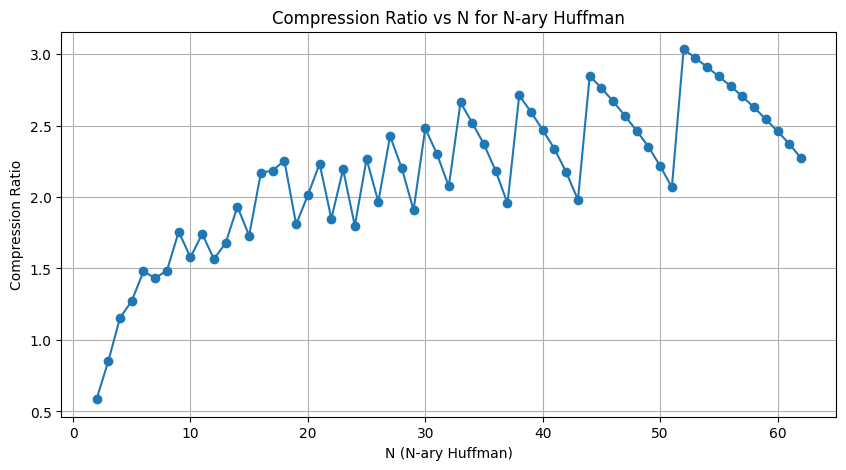

In [9]:
def plot_compression_vs_N(img, max_base=62):
    """
    Computes and plots Huffman compression ratio for N-ary Huffman
    with N from 2 up to max_base.
    
    Parameters:
        img : np.ndarray
            Input image array (int or float).
        max_base : int
            Maximum N value to test (≤ length of SYMBOLS).
    """
    ratios = []
    bases = list(range(2, max_base + 1))
    
    flat = img.flatten()
    orig_bits = img.nbytes * 8
    
    for base in bases:
        freqs = Counter(flat)
        codebook = get_huffman_codebook(freqs, base)
        encoded = [codebook[val] for val in flat]

        # Estimate encoded data size
        encoded_bits = sum(len(sym) for sym in encoded) * 8

        # Estimate dictionary size
        dict_bits = 0
        for k, v in codebook.items():
            key_bits = 32  # assume float/int 32 bits
            value_bits = len(v) * 8
            dict_bits += key_bits + value_bits

        total_bits = encoded_bits + dict_bits
        compression_ratio = orig_bits / total_bits
        ratios.append(compression_ratio)
    
    plt.figure(figsize=(10, 5))
    plt.plot(bases, ratios, marker='o')
    plt.xlabel("N (N-ary Huffman)")
    plt.ylabel("Compression Ratio")
    plt.title("Compression Ratio vs N for N-ary Huffman")
    plt.grid(True)
    plt.show()

img = mpimg.imread("C:/Users/DEVESH PALO/projects/Image_Compression_Algorithms/samples/kodak/kodim14.png") 
plot_compression_vs_N(img)

Image shape: (512, 768, 3) dtype: float32
Decoded identical to original: True
Compression ratio: 2.077
PSNR: inf dB
SSIM: 1.0000


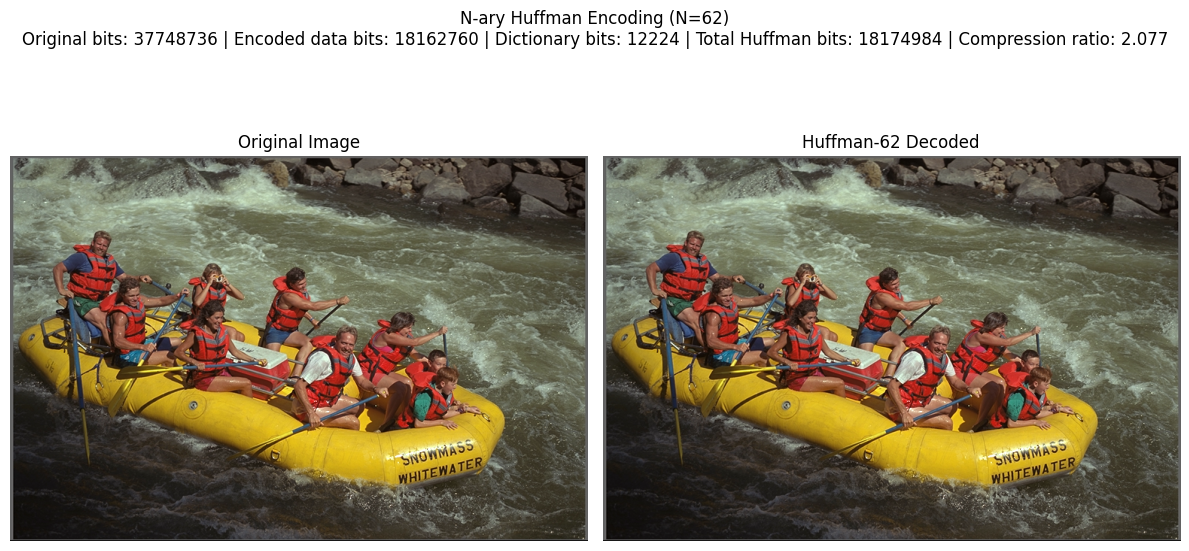

In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np
# After decoding the image
if __name__ == "__main__":
    import matplotlib.image as mpimg

    img = mpimg.imread("C:/Users/DEVESH PALO/projects/Image_Compression_Algorithms/samples/kodak/kodim14.png")
    if img.dtype in [np.float32, np.float64]:
        img = np.round(img, 4)
    print("Image shape:", img.shape, "dtype:", img.dtype)
    base = 62  # Now maximum supported N
    ratio, orig_bits, encoded_bits, dict_bits, total_bits, codebook, encoded = calculate_huffman_compression_ratio(img, base)
    decoded = huffman_decode(encoded, codebook, img.shape, img.dtype)
    print(f"Decoded identical to original: {np.allclose(img, decoded)}")
    print(f"Compression ratio: {ratio:.3f}")

    # --- PSNR and SSIM ---
    # If image is float, ensure range is correct for metrics
    data_range = 1.0 if np.issubdtype(img.dtype, np.floating) else 255
    psnr_val = psnr(img, decoded, data_range=data_range)
    if img.ndim == 3 and img.shape[2] in [3, 4]:
        ssim_val = ssim(img, decoded, data_range=data_range, channel_axis=-1)
    else:
        ssim_val = ssim(img, decoded, data_range=data_range)
    print(f"PSNR: {psnr_val:.2f} dB")
    print(f"SSIM: {ssim_val:.4f}")

    display_side_by_side(img, decoded, base, ratio, orig_bits, encoded_bits, dict_bits, total_bits)

Decoded identical to original (allclose): True
Compression ratio: 2.077
PSNR: inf dB
SSIM: 1.0000


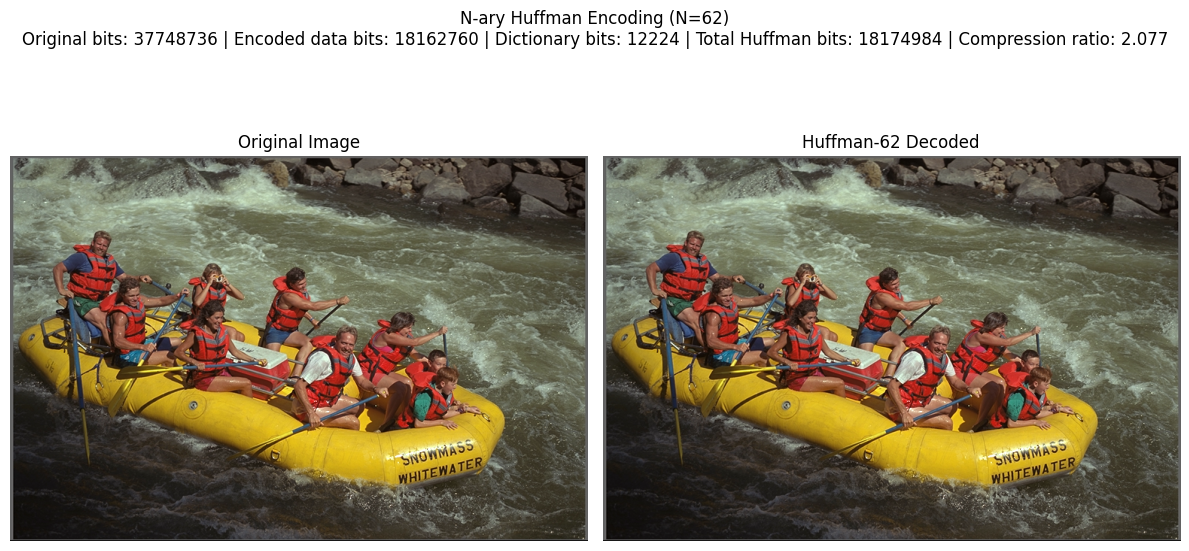

In [ ]:
import csv
import json
import os
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np

def _compute_data_range(img):
    """Return appropriate data_range for skimage metrics based on dtype."""
    if np.issubdtype(img.dtype, np.floating):
        # assume floats are in [0,1]
        return 1.0
    # integer types: infer from dtype (common images are uint8)
    # fallback to 255 for typical 8-bit images
    info = np.iinfo(img.dtype) if np.issubdtype(img.dtype, np.integer) else None
    return float(info.max) if info is not None else 255.0

def compute_psnr_ssim(orig, recon, *, ensure_same_shape=True):
    """
    Compute PSNR and SSIM between orig and recon images.
    Returns (psnr_val, ssim_val).
    Handles grayscale and color (3 or 4 channels) images.
    """
    if ensure_same_shape and orig.shape != recon.shape:
        raise ValueError(f"orig and recon shapes differ: {orig.shape} vs {recon.shape}")

    # Convert to same dtype if needed for comparison (but do not rescale)
    # We trust that decoded was produced with same dtype/range as orig
    data_range = _compute_data_range(orig)
    psnr_val = psnr(orig, recon, data_range=data_range)

    # structural_similarity requires channel_axis for multichannel images (skimage>=0.19)
    if orig.ndim == 3 and orig.shape[2] in (3, 4):
        ssim_val = ssim(orig, recon, data_range=data_range, channel_axis=-1)
    else:
        ssim_val = ssim(orig, recon, data_range=data_range)

    return float(psnr_val), float(ssim_val)

def record_metrics_csv(csv_path, image_name, psnr_val, ssim_val, extra=None):
    """
    Append a line to csv_path with columns:
    image_name, psnr, ssim, timestamp, extra_json
    Creates file with header if it doesn't exist.
    `extra` can be any JSON-serializable object (e.g. compression ratio, bits).
    """
    header = ["image_name", "psnr_db", "ssim", "timestamp", "extra_json"]
    row = {
        "image_name": image_name,
        "psnr_db": float(psnr_val),
        "ssim": float(ssim_val),
        "timestamp": __import__("datetime").datetime.utcnow().isoformat() + "Z",
        "extra_json": json.dumps(extra) if extra is not None else ""
    }
    write_header = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=header)
        if write_header:
            writer.writeheader()
        writer.writerow(row)

def save_metrics_json(json_path, image_name, psnr_val, ssim_val, extra=None):
    payload = {
        "image_name": image_name,
        "psnr_db": float(psnr_val),
        "ssim": float(ssim_val),
        "timestamp": __import__("datetime").datetime.utcnow().isoformat() + "Z",
        "extra": extra
    }
    with open(json_path, "w") as f:
        json.dump(payload, f, indent=2)

# ----------------------------
# Example: integrate into your main block
# ----------------------------
# Replace your PSNR/SSIM section with this (or call from there)

if __name__ == "__main__":
    import matplotlib.image as mpimg
    img_path = "C:/Users/DEVESH PALO/projects/Image_Compression_Algorithms/samples/kodak/kodim14.png"
    img = mpimg.imread(img_path)
    if img.dtype in [np.float32, np.float64]:
        # your code used rounding earlier; keep same behavior if desired
        img = np.round(img, 4)

    # (assume you already computed these earlier in your script)
    base = 62
    ratio, orig_bits, encoded_bits, dict_bits, total_bits, codebook, encoded = calculate_huffman_compression_ratio(img, base)
    decoded = huffman_decode(encoded, codebook, img.shape, img.dtype)

    print("Decoded identical to original (allclose):", np.allclose(img, decoded))
    print(f"Compression ratio: {ratio:.3f}")

    # compute metrics using helper
    psnr_val, ssim_val = compute_psnr_ssim(img, decoded)

    # print to console
    print(f"PSNR: {psnr_val:.2f} dB")
    print(f"SSIM: {ssim_val:.4f}")

    # optionally record to CSV or JSON
    csv_out = "compression_metrics.csv"         # appends if exists
    json_out = "last_compression_metrics.json"  # overwrite each run
    image_name = os.path.basename(img_path)

    extra = dict(
        compression_ratio=float(ratio),
        orig_bits=int(orig_bits),
        encoded_bits=int(encoded_bits),
        dict_bits=int(dict_bits),
        total_bits=int(total_bits)
    )

    record_metrics_csv(csv_out, image_name, psnr_val, ssim_val, extra=extra)
    save_metrics_json(json_out, image_name, psnr_val, ssim_val, extra=extra)

    # keep your display call
    display_side_by_side(img, decoded, base, ratio, orig_bits, encoded_bits, dict_bits, total_bits)
